In [1]:
import os
import math
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
image_annotation_path = os.path.join(os.getcwd(), "..", "dataset", "annotations")
images = list(filter(lambda filename: filename.split(".")[-1] != "xlsx", os.listdir(image_annotation_path)))
image_path = os.path.join(os.getcwd(), "..", "dataset", "box")
df = pd.read_excel(os.path.join(image_annotation_path, "mandible measurement.xlsx"))

## Load Image

In [3]:
def display(img, axis = True, convert_color = True, gray = False):
    plt.figure(figsize=(20, 10))
    if not convert_color:
        rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        plt.imshow(rgb, cmap=None if not gray else "gray")
    else:
        plt.imshow(img, cmap=None if not gray else "gray")
    
    if not axis:
        plt.axis("off")
        
    plt.show()

In [4]:
img_index = 0
img_annotation = cv.imread(os.path.join(image_annotation_path, images[img_index]))
img = cv.imread(os.path.join(image_path, "{}.tiff".format(images[img_index].split(" ")[0])))

In [5]:
def multi_display(img_list, axis = True, convert_color = True, gray = False):
    n = len(img_list)
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(20, 10))
    
    for img, ax in zip(img_list, axes):
        if convert_color:
            rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB) 
            ax.imshow(rgb, cmap=None if not gray else "gray")
        else:
            ax.imshow(img, cmap=None if not gray else "gray")
         
        if not axis:
           ax.axis("off")   
    
    fig.tight_layout()

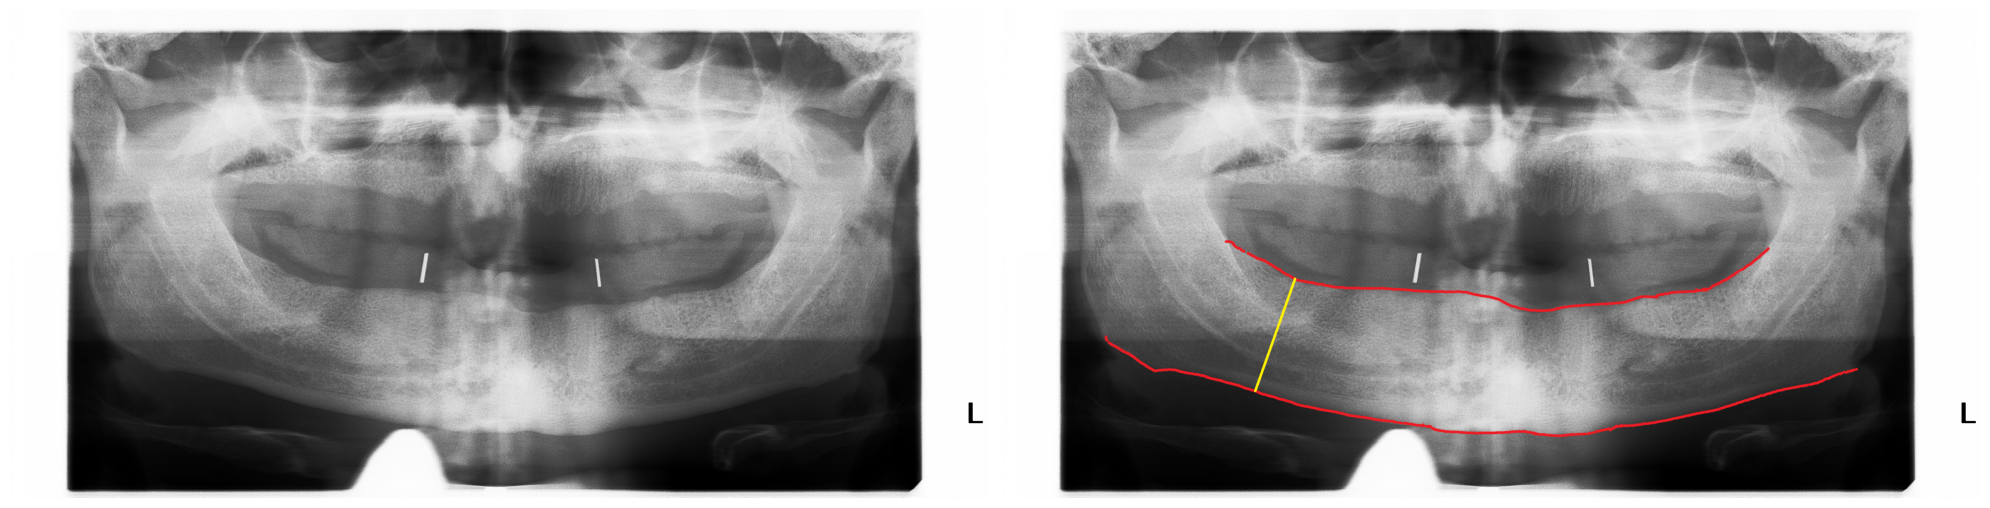

In [6]:
multi_display([img, img_annotation], False)

## Get Pin

In [7]:
# Region of Interest
roi_x1 = round(img.shape[1] * 0.3)
roi_y1 = round(img.shape[0] * 0.3)  
roi_x2 = round(img.shape[1] * 0.7)
roi_y2 = round(img.shape[0] * 0.7)

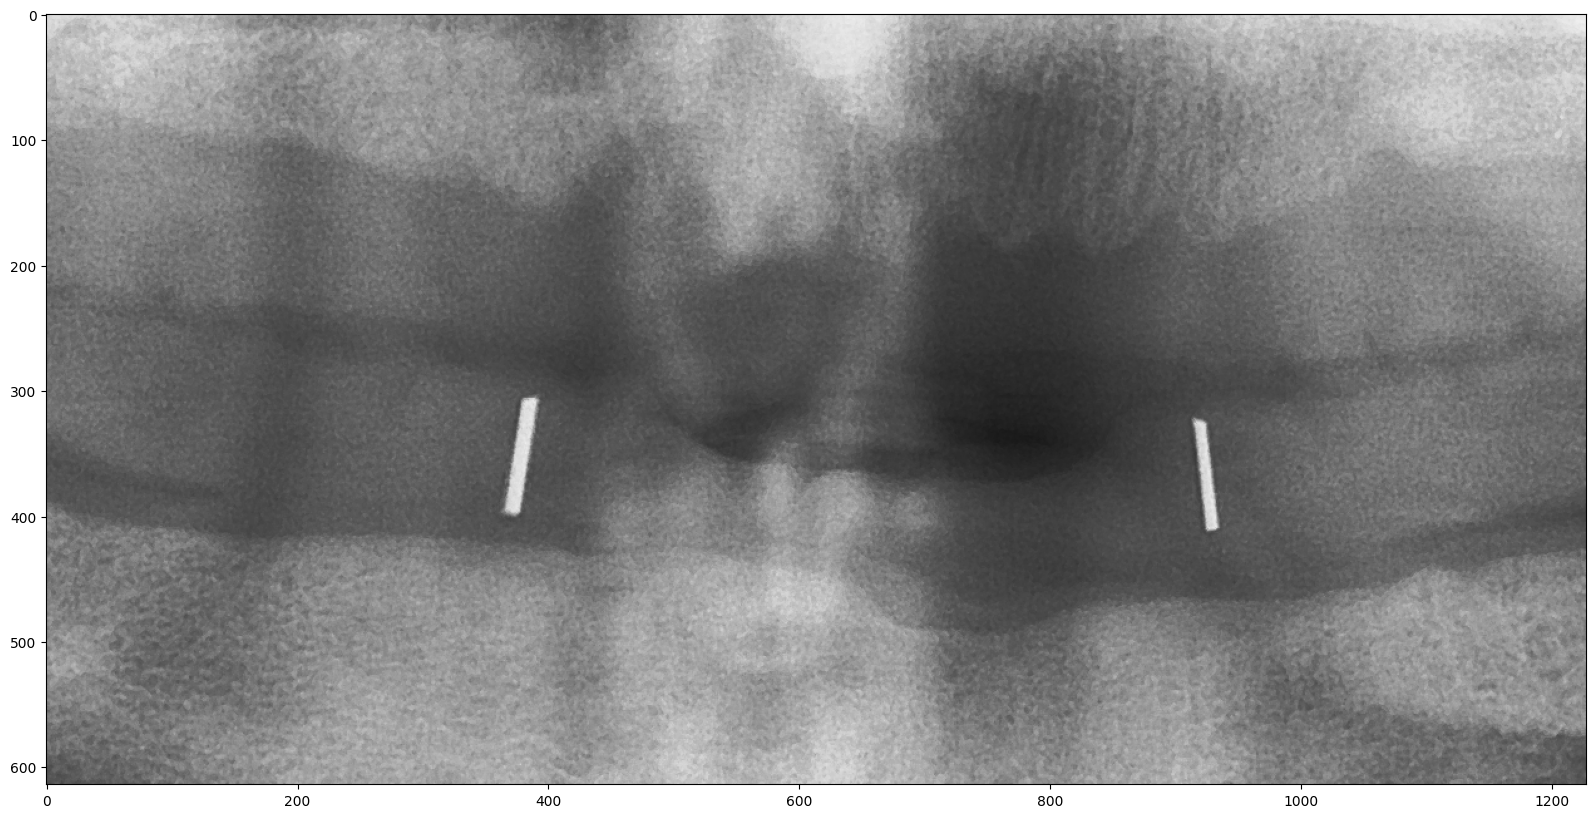

In [8]:
display(img[roi_y1:roi_y2, roi_x1:roi_x2])

In [9]:
edges = cv.Canny(img, 100, 255)
contour_list, hierarchy = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

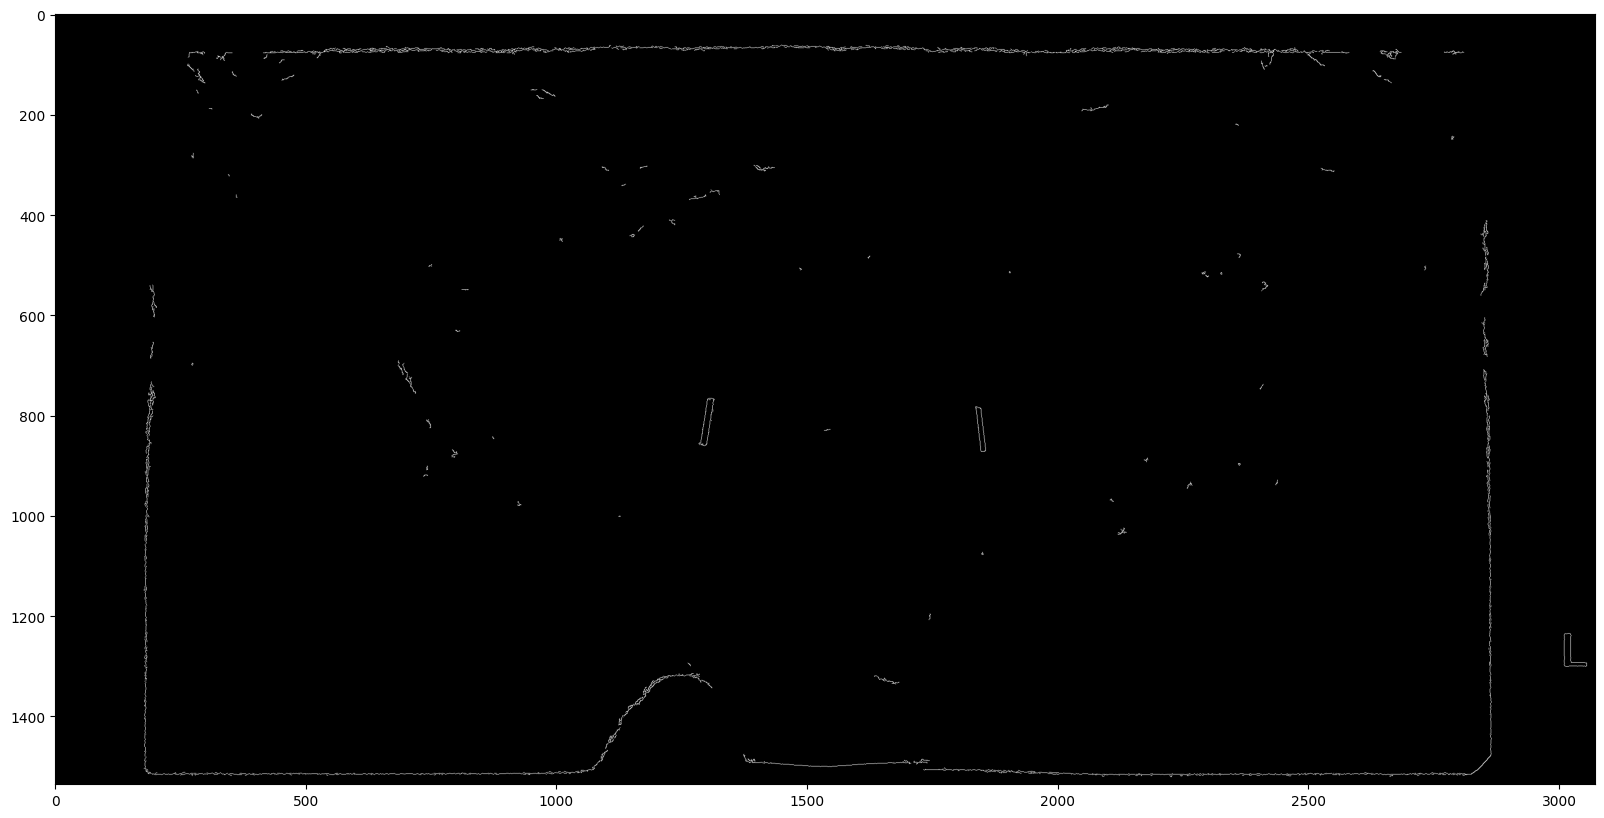

In [10]:
display(edges, convert_color=False, gray=True)

In [11]:
def is_contour_in_roi(xs, ys):
    x_axis = min(xs) >= roi_x1 and max(xs) < roi_x2
    y_axis = min(ys) >= roi_y1 and max(ys) < roi_y2
    return x_axis and y_axis

90.24411338142782
89.05054744357274
92.04890004774636


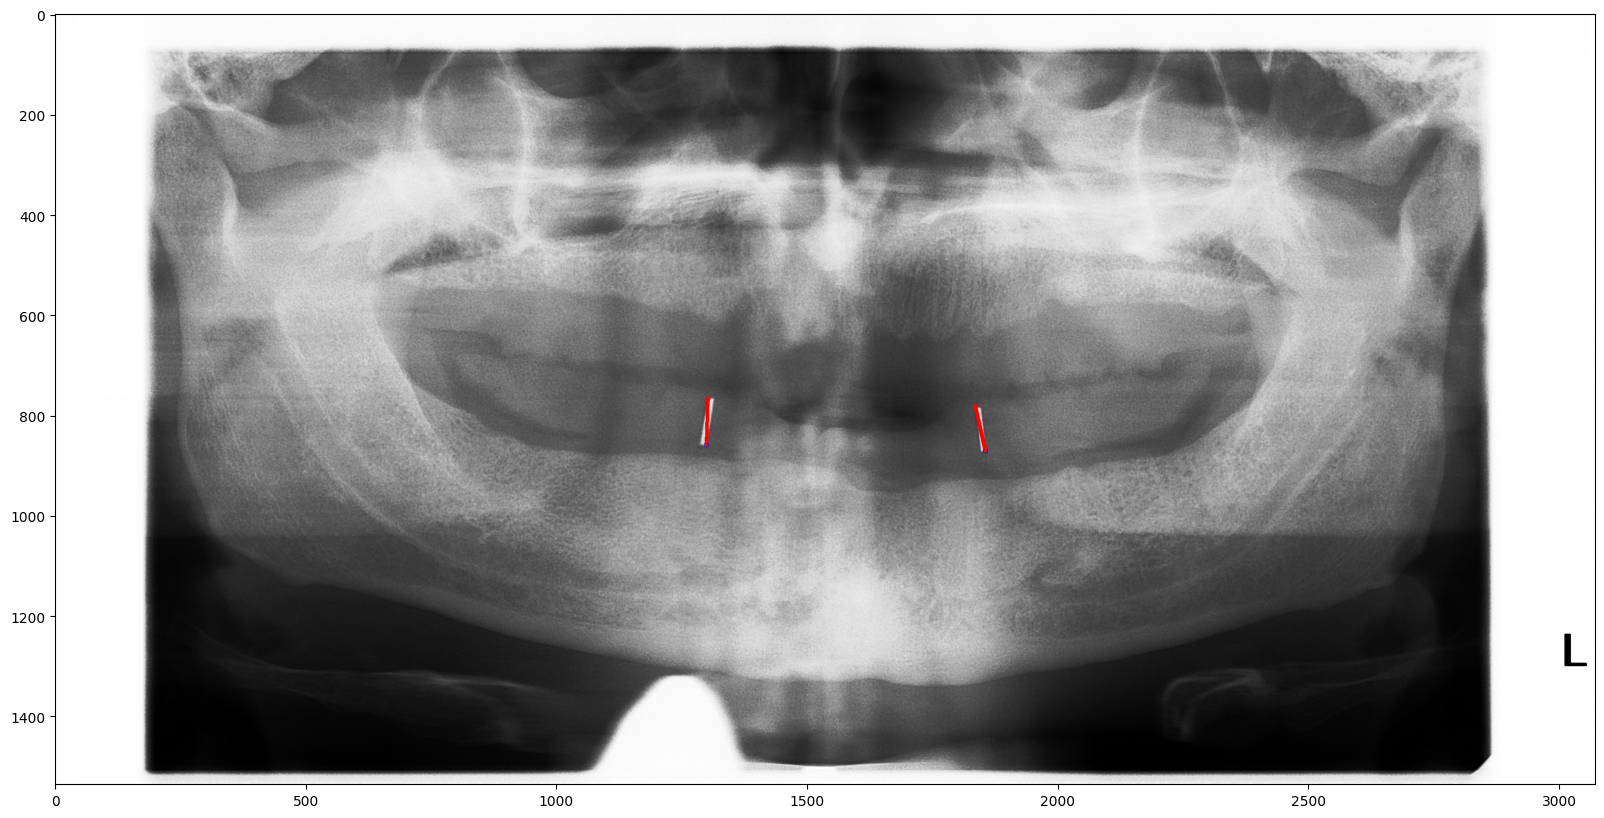

In [12]:
img_copy = img.copy()

for contours in contour_list:
    contours = contours.reshape(contours.shape[0], 2)
    xs, ys = contours.T
    if is_contour_in_roi(xs, ys):
        sorted_list = sorted(contours.tolist(), key=lambda point: sum(point))
        
        x_len = max(xs) - min(xs)
        y_len = max(ys) - min(ys)
        
        
        if y_len > 40:
            cv.circle(img_copy, sorted_list[0], 5, (255, 0, 0), 1)
            cv.circle(img_copy, sorted_list[-1], 5, (0, 0, 255), 1)
            cv.line(img_copy, sorted_list[0], sorted_list[-1], (255, 0, 0), 5)
            x1, y1 = sorted_list[0]
            x2, y2 = sorted_list[-1]
            
            ldx, ldy = max(x2, x1) - min(x2, x1), max(y2, y1) - min(y2, y1)
            line_length = math.sqrt((ldx ** 2) + (ldy ** 2))
            print(line_length)
        
display(img_copy)

## Get Annotation Lines

In [13]:
def get_annotation_lines(img: np.array):
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv_img, (1, 0, 0), (255, 255, 255))
    return mask

def lines_to_points(mask: np.array):
    top = []
    bottom = []

    for x in range(mask.shape[1]):
        points = np.argwhere(mask[:, x] > 0)
        
        if points.shape[0] > 0:
            bottom.append((x, max(points)[0]))
            
            if max(points) - min(points) > 100:
                top.append((x, min(points)[0]))
                
    top = np.array(top, dtype=np.uint32)
    bottom = np.array(bottom, dtype=np.uint32)
    
    return top, bottom

In [14]:
annotation_lines = get_annotation_lines(img_annotation)

In [15]:
def get_minimum_height(annotation_lines_mask, img):
    img_copy0 = img.copy()
    top_points, bottom_points = lines_to_points(annotation_lines_mask)
    global_length = []
    gtx, gty = [], []
    gbx, gby = [], []
    
    for i in range(0, len(top_points) - 1):
        x1, y1 = top_points[i]
        
        length = []
        bxs, bys = [], []
        
        for bx, by in bottom_points:
            ldx, ldy = max(bx, x1) - min(bx, x1), max(by, y1) - min(by, y1)
            line_length = math.sqrt((ldx ** 2) + (ldy ** 2))
            length.append(line_length)
            bxs.append(bx)
            bys.append(by)
        
        idx = length.index(min(length))
        global_length.append(min(length))
        gtx.append(x1)
        gty.append(y1)
        gbx.append(bxs[idx])
        gby.append(bys[idx])
    
    i = global_length.index(min(global_length))
    cv.line(img_copy0, (gtx[i], gty[i]), (gbx[i], gby[i]), (255, 255, 0), 3)
    
    multi_display([img_copy0, annotation_lines_mask], False, True)
    
    return min(global_length)

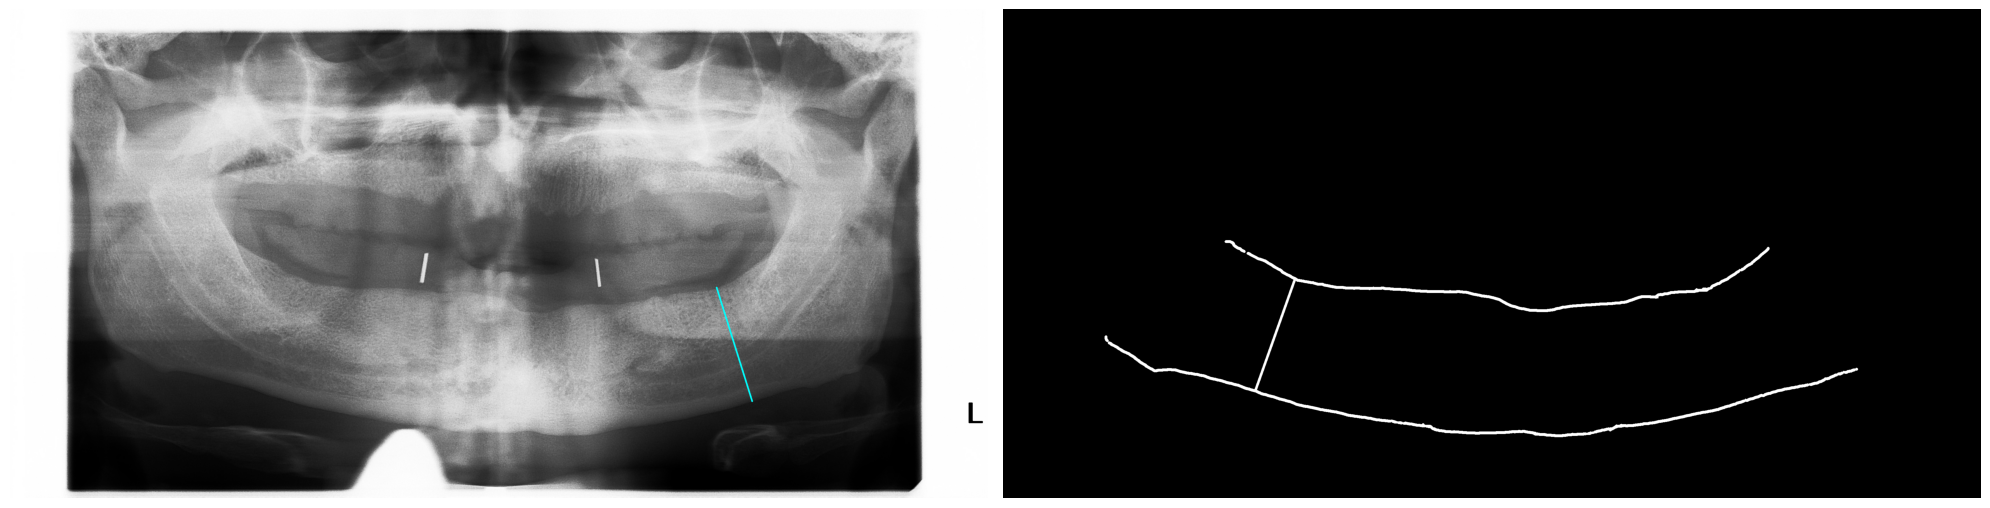

In [16]:
min_height = get_minimum_height(annotation_lines, img)

In [17]:
(min_height / 92.04890004774636) * 10

40.751236587013004

In [18]:
df

,Case Number,Mandible height 1st measurement,Mandible height 2nd measurement,Mandible height 3rd measurement,Type of mandible height
0,#911876,40.07,40.15,40.24,1
1,#909576,12.15,12.29,12.35,3
2,#0613818,18.86,18.88,18.79,2
3,#0413594,16.04,16.57,16.07,2
4,#0103924,18.53,18.57,18.79,2


In [19]:
images[img_index]

'911876 - 2.tiff'